<a href="https://colab.research.google.com/github/87tana/Brain_Tumor_Classification/blob/main/Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [3]:
print("OS Version & Details: ")
!lsb_release -a

OS Version & Details: 
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.2 LTS
Release:	22.04
Codename:	jammy


## **3. Importing Required Libraries**

In [4]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from plotly.subplots import make_subplots


from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold

from sklearn.metrics import *

print(f'Tensorflow Version: {tf.__version__}.')
import sys
import os
import math


Tensorflow Version: 2.13.0.




```
# This is formatted as code
```

## **4. Setting Up the Environment**

In [5]:
gpu_device_location = tpu_device_location = cpu_device_location = None

if os.environ['COLAB_GPU'] == '1':
    print("Allocated GPU Runtime Details:")
    !nvidia-smi
    print()
    try:
        import pynvml
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        gpu_device_name = pynvml.nvmlDeviceGetName(handle)

        if gpu_device_name not in {b'Tesla T4', b'Tesla P4', b'Tesla P100-PCIE-16GB'}:
            raise Exception("Unfortunately this instance does not have a T4, P4 or P100 GPU.\nSometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100.\nIf you get Tesla K80 then you can factory reset your runtime to get another GPUs.")
    except Exception as hardware_exception:
        print(hardware_exception, end = '\n\n')
    gpu_device_location = tf.test.gpu_device_name()
    print(f"{gpu_device_name.decode('utf-8')} is allocated sucessfully at location: {gpu_device_location}")
elif 'COLAB_TPU_ADDR' in os.environ:
    tpu_device_location = f"grpc://{os.environ['COLAB_TPU_ADDR']}"
    print(f"TPU is allocated successfully at location: {tpu_device_location}.")
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_location)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.TPUStrategy()
else:
    cpu_device_location = "/cpu:0"

### **4.1 Installation of `tree` Utility Using `Bash`.**  

In [6]:
%%bash
RED_COLOR='\033[0;31m'
NO_COLOR='\033[0m'
pkg_name=tree
dpkg -s $pkg_name &> /dev/null
if [ "$?" -ne "0" ]
    then
        echo "Installing tree utility..."
        apt-get autoclean
        apt-get autoremove
        apt-get install $pkg_name
        if [ "$?" -eq "0" ]
            then
                echo -e ${RED_COLOR}"tree utility installed sucessfully.\n"${NO_COLOR}
        fi
    else
        echo "tree utility is already installed."
fi
tree --version

Installing tree utility...
Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (218 kB/s)
Selecting previously unselected package tree.
(Reading database ... 120876 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
tree utility installed sucessfully.

tree v2.0.2

### **4.2 Display of File Structure**

In [7]:
!tree -d -C "gdrive/MyDrive/Deep_Learning_Course_Project"

gdrive/MyDrive/Deep_Learning_Course_Project  [error opening dir]

0 directories


### **4.3 Setting Up Paths to Root and Data Directories**

In [8]:
ROOT_DIR = r"drive/MyDrive/Tumor_Classification"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Brain-Tumor-Dataset")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
MASK_DIR = os.path.join(DATA_ROOT_DIR, 'Tumor-Mask')
assert os.path.isdir(ROOT_DIR) and os.path.isdir(DATA_ROOT_DIR) and os.path.isdir(TRAIN_DIR) and os.path.isdir(MASK_DIR)
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor', 'no_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
MASK_DATA_PATHS = [os.path.join(MASK_DIR, tumor_name) for tumor_name in TUMOR_CLASS[:-1]]

## **5. Data Preprocessing and Exploratory Data Analysis**

In [9]:
# Create a Pandas Series that counts the number of image files in each directory specified in IMAGE_DATA_PATHS,
# The counts are associated with tumor classes defined in TUMOR_CLASS.
data_distribution_count = pd.Series(
    [len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
    index=TUMOR_CLASS
)

# Display the data_distribution_count Series.
data_distribution_count


meningioma          708
glioma             1426
pituitary_tumor     930
no_tumor            395
dtype: int64

### **5.1 Data Distribution Visualization for each tumor class**

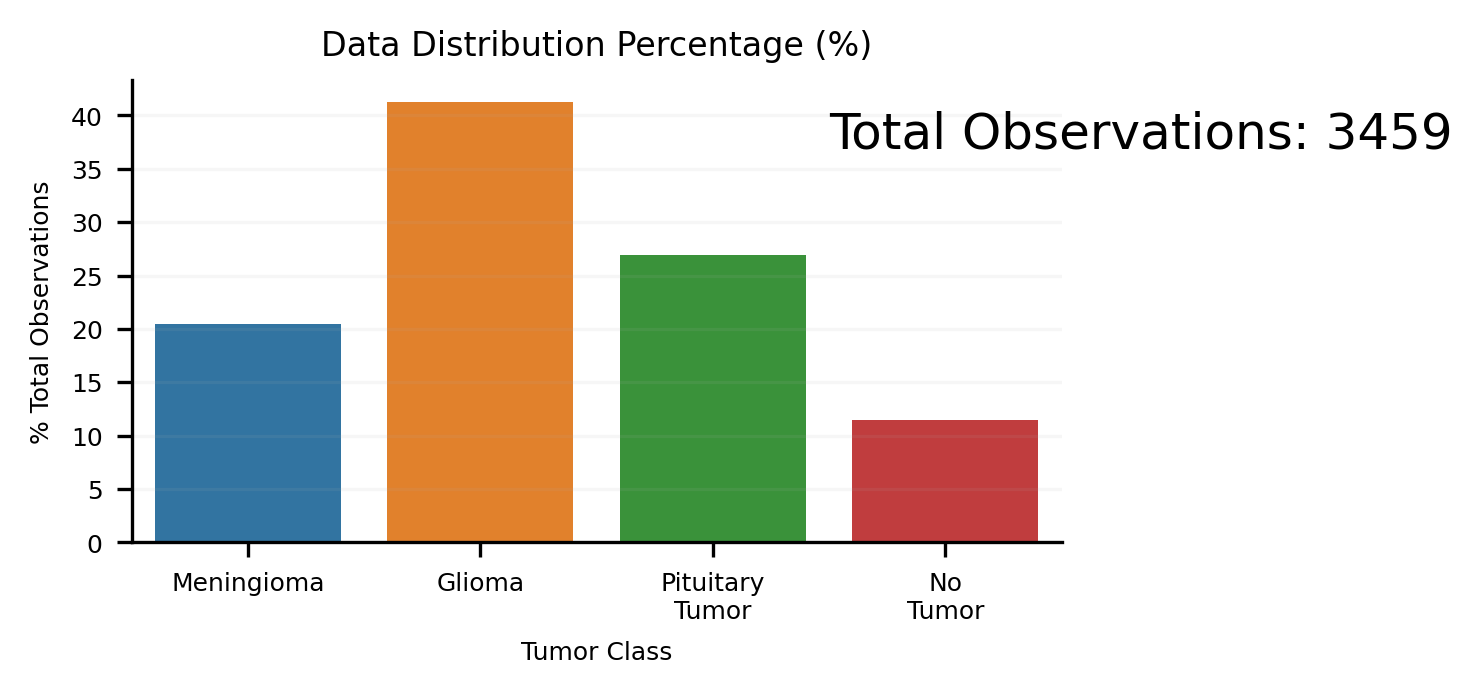

In [19]:
fig, axis = plt.subplots(figsize = (4, 2))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 8)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 6)
axis.set_ylabel("% Total Observations", fontsize = 6)
axis.tick_params(which = 'major', labelsize = 6)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

### **5.2 Visualisation of Brain MRI Dataset**

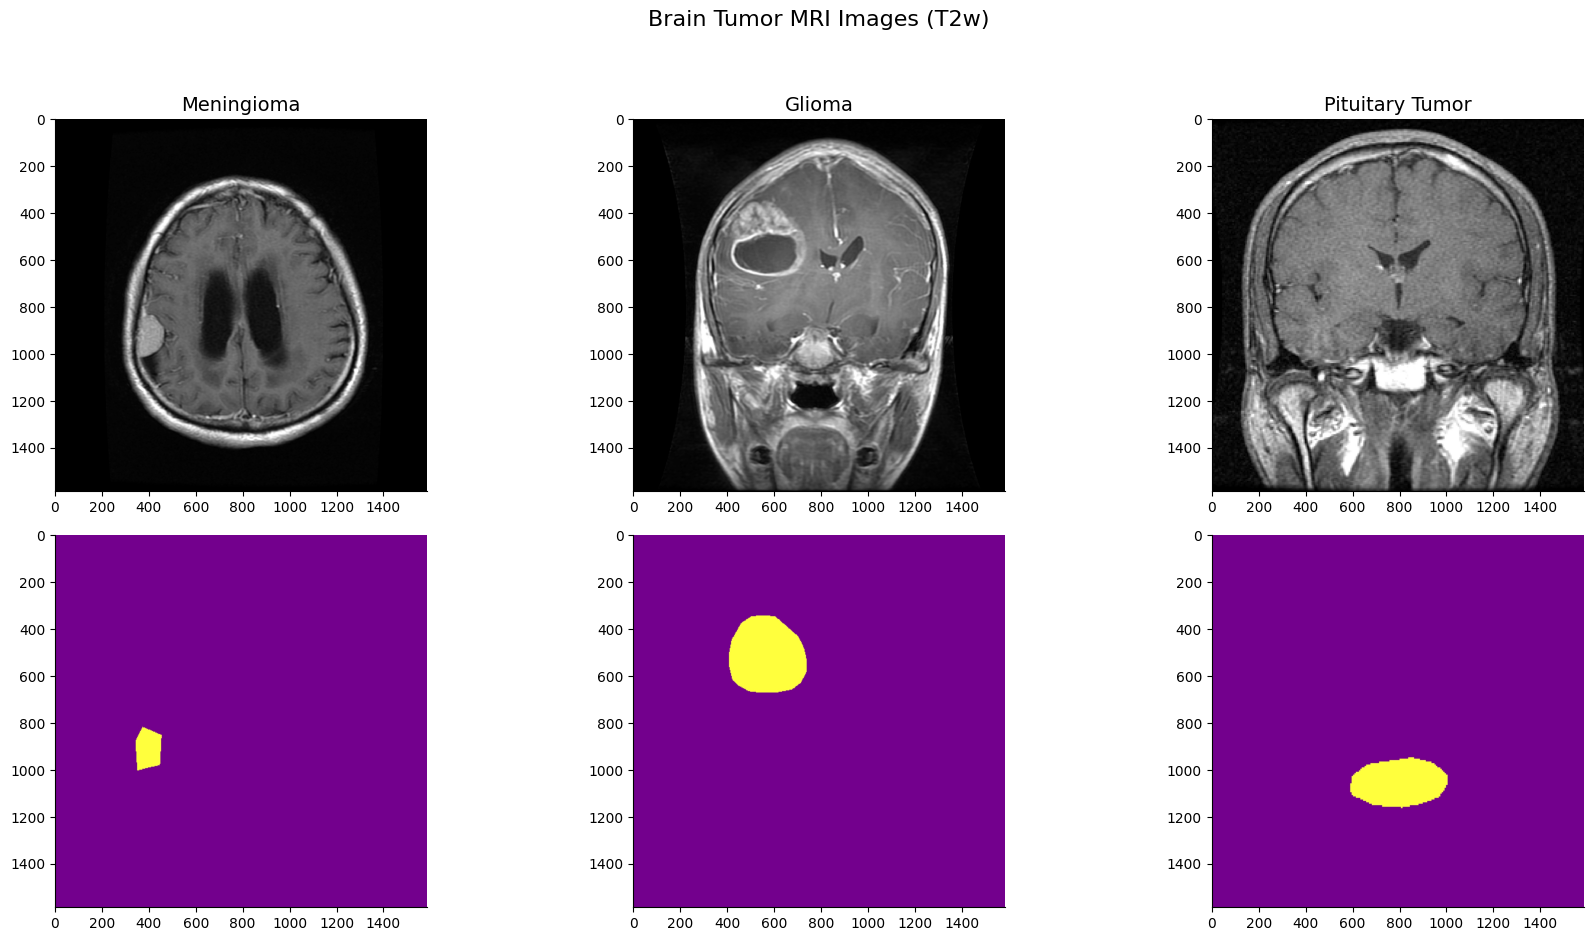

In [ ]:
BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(TUMOR_CLASS[:-1], IMAGE_DATA_PATHS[:-1], axes[:3]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)

for filename, curr_axis in zip(MASK_DATA_PATHS, axes[3:]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    mask_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(mask_enhancer.enhance(BRIGHTNESS_FACTOR))
fig.tight_layout()
sns.despine()

In [ ]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))

In [ ]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

,image_filepaths,tumor_class
0,drive/MyDrive/Tumor_Classification/Brain-Tumor...,meningioma
1,drive/MyDrive/Tumor_Classification/Brain-Tumor...,meningioma
2,drive/MyDrive/Tumor_Classification/Brain-Tumor...,pituitary_tumor
3,drive/MyDrive/Tumor_Classification/Brain-Tumor...,pituitary_tumor
4,drive/MyDrive/Tumor_Classification/Brain-Tumor...,pituitary_tumor


In [ ]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  3459 non-null   object
 1   tumor_class      3459 non-null   object
dtypes: object(2)
memory usage: 54.2+ KB


In [ ]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df,
                                                      train_size = 0.70,
                                                      random_state = 42,
                                                      stratify = image_data_paths_df.tumor_class)

train_data, validation_data = train_test_split(intermediate_train_data,
                                               train_size = 0.80,
                                               random_state = 42,
                                               stratify = intermediate_train_data.tumor_class)

<ipython-input-12-2f86acd4e269>:7: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  curr_axis.grid(False, alpha = 0.1)


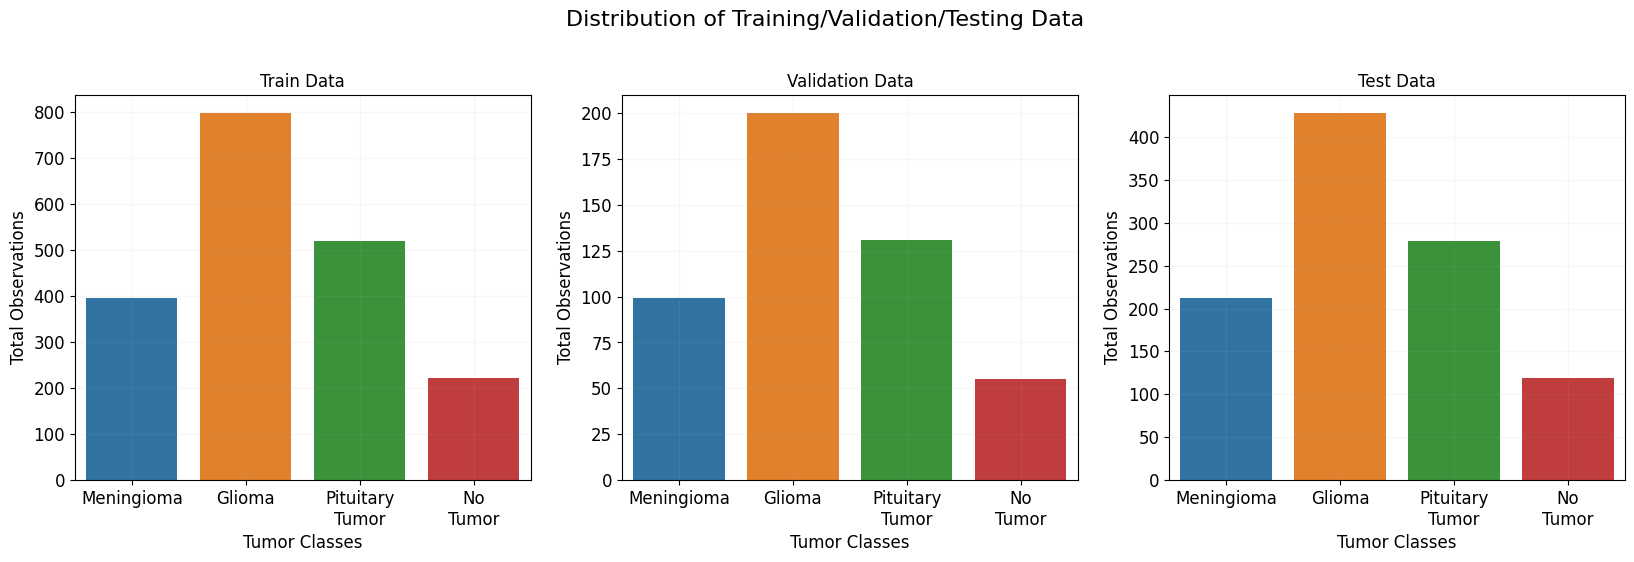

In [ ]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
sns.countplot(x = train_data.tumor_class, order = TUMOR_CLASS, ax = axes[0])
sns.countplot(x = validation_data.tumor_class, order = TUMOR_CLASS, ax = axes[1])
sns.countplot(x = test_data.tumor_class, order = TUMOR_CLASS, ax = axes[2])
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])

## **7. Data/Image Augmentation**
* Image augmentation is usually used to increase the image dataset and also to make the network more robust against translation invariance. Image augmentation is defined as creating duplicates of the original image datasets by flipping, rotating, zooming, and adjusting brightness.

* We will use data/image augmentation using `ImageDataGenerator` class to train the model on different types of combinations formed by rotation, flipping, changing the brightness etc of an image so as to increase our model accuracy.

In [ ]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15,
                            width_shift_range = 0.1,
                            zoom_range = 0.01,
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [ ]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [ ]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data,
                                                                  x_col = 'image_filepaths',
                                                                  y_col = 'tumor_class',
                                                                  seed = 42,
                                                                  batch_size = batch_size,
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1936 validated image filenames belonging to 4 classes.
Found 485 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.


In [ ]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')

print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')

print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Validation Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Testing Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)


### **7.1 Training Data Images Glimpse**

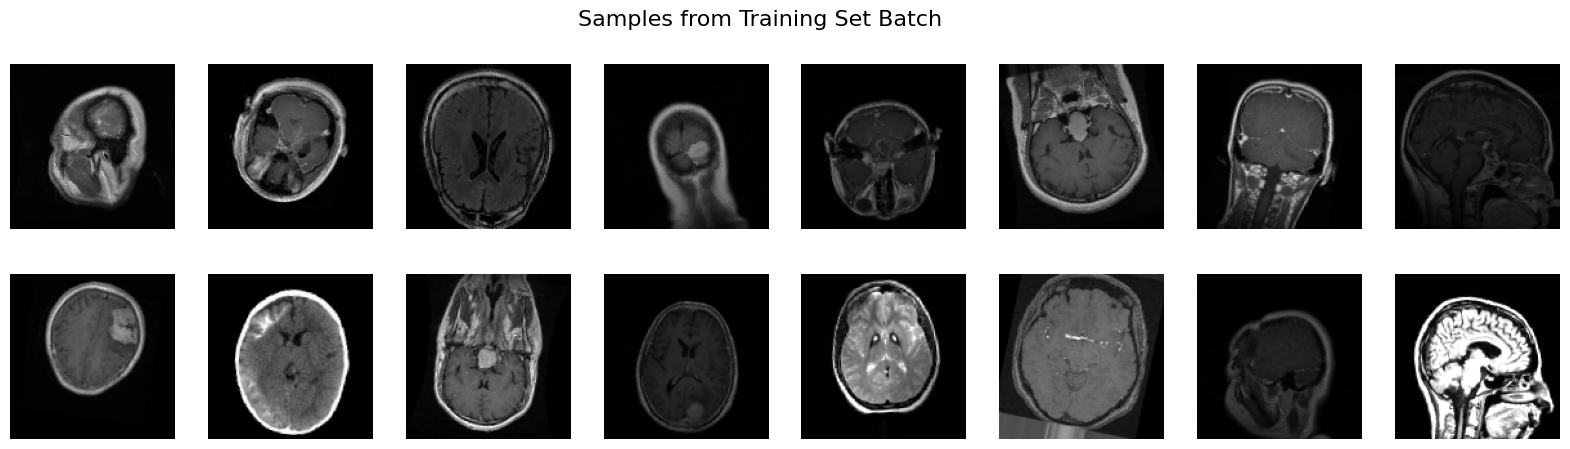

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

### **7.2 Validation Data Images Glimpse**

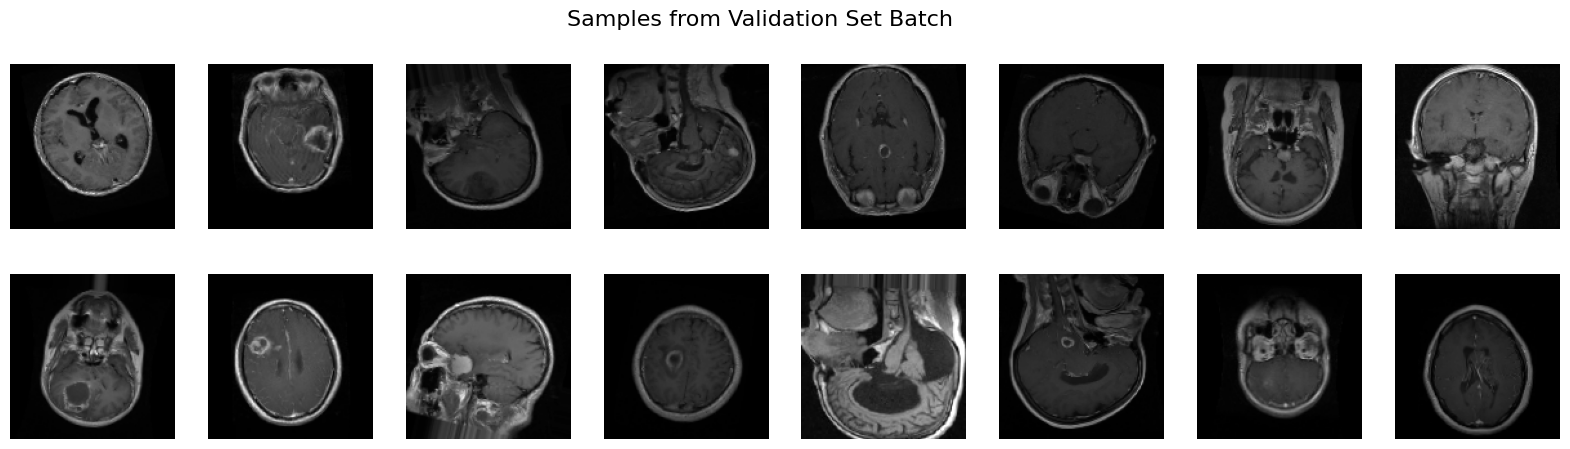

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

### **7.3 Testing Data Images Glimpse**

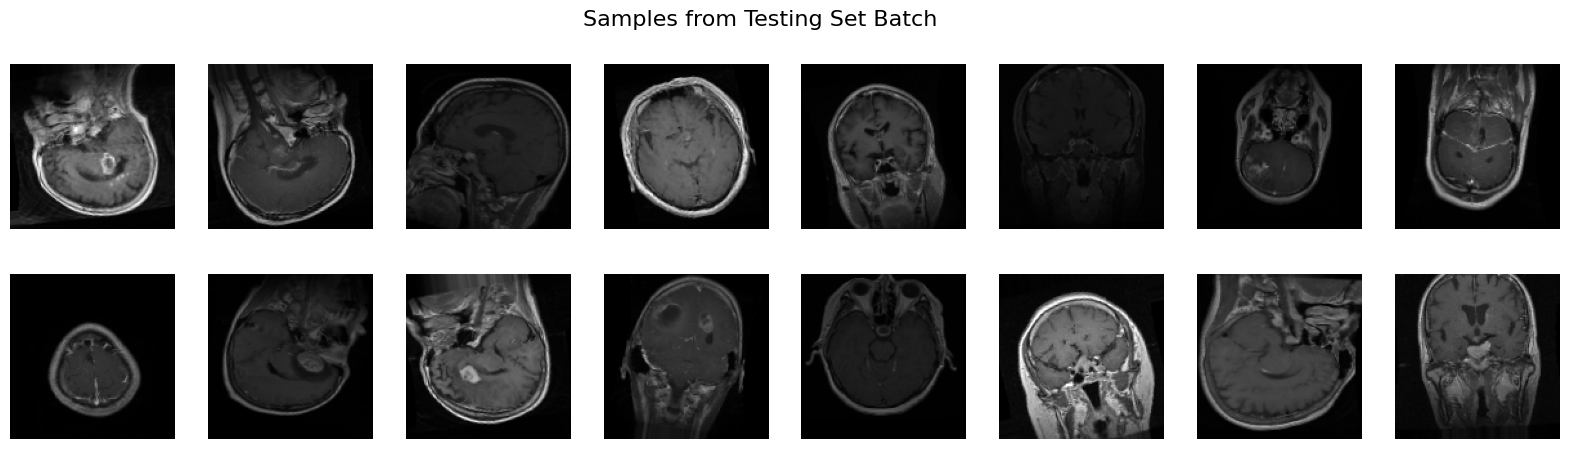

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

## **8. Model Development**

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [ ]:
import os

# Create the directories if they don't exist
os.makedirs(ROOT_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(MLP_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(ALEXNET_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(INCEPTIONV3_CHECKPOINT_DIR_PATH, exist_ok=True)

# Now, the assert statement should pass without errors
assert os.path.isdir(ROOT_CHECKPOINT_DIR_PATH) and os.path.isdir(MLP_CHECKPOINT_DIR_PATH) and os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)

In [ ]:
mlp_cp_callback = ModelCheckpoint(MLP_CHECKPOINT_DIR_PATH,
                                  monitor = 'val_accuracy',
                                  verbose = 1,
                                  save_weights_only = True,
                                  save_freq =  'epoch')

alexnet_cp_callback = ModelCheckpoint(ALEXNET_CHECKPOINT_DIR_PATH,
                                      monitor = 'val_accuracy',
                                      verbose = 1,
                                      save_weights_only = True,
                                      save_freq = 'epoch')

inceptionv3_cp_callback = ModelCheckpoint(INCEPTIONV3_CHECKPOINT_DIR_PATH,
                                          monitor = 'val_accuracy',
                                          verbose = 1,
                                          save_weights_only = True,
                                          save_freq = 'epoch')

In [ ]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [ ]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Pedicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [ ]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds, squared = False), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

### **8.1 Multi-Layer Perceptron**

#### **8.1.1 Development of Multi-Layer Perceptron Model**

In [ ]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten-Layer (Flatten)     (None, 49152)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 2048)              100665344 
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 2048)              0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 1024)              2098176   
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 1024)              0         
                                                                 
 Hidden-Layer-3 (Dense)      (None, 512)               524800    
                                                                 
 Dropout-Layer-3 (Dropout)   (None, 512)               0

#### **8.1.2 Training and Validation of Multi-Layer Perceptron Based Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 100,
                                      callbacks = [early_stopping])

Epoch 1/100
61/61 [==============================] - 1155s 19s/step - loss: 4.7413 - accuracy: 0.4292 - val_loss: 1.1777 - val_accuracy: 0.5918
Epoch 2/100
61/61 [==============================] - 152s 2s/step - loss: 1.1945 - accuracy: 0.5279 - val_loss: 1.1443 - val_accuracy: 0.5753
Epoch 3/100
61/61 [==============================] - 159s 3s/step - loss: 1.1696 - accuracy: 0.5387 - val_loss: 1.1018 - val_accuracy: 0.5381
Epoch 4/100
61/61 [==============================] - 157s 3s/step - loss: 1.1445 - accuracy: 0.5403 - val_loss: 1.0841 - val_accuracy: 0.5753
Epoch 5/100
61/61 [==============================] - 160s 3s/step - loss: 1.0903 - accuracy: 0.5702 - val_loss: 1.1994 - val_accuracy: 0.4866
Epoch 6/100
61/61 [==============================] - 152s 2s/step - loss: 1.0936 - accuracy: 0.5739 - val_loss: 1.0559 - val_accuracy: 0.6000
Epoch 7/100
61/61 [==============================] - 172s 3s/step - loss: 1.0719 - accuracy: 0.5744 - val_loss: 1.0092 - val_accuracy: 0.6062
Epoc

UnknownError: ignored

In [ ]:
#### **8.1.3 Multi-Layer Perceptron Based Model Training Process Statistics**


In [ ]:
training_process_viz(pd.DataFrame(mlp_train_history.history),
                     plot_title = 'Multilayer Perceptron Training Statistics')

In [ ]:
#### **8.1.4 Confusion Matrix for Multi-Layer Perceptron Based Model**

In [ ]:
confusion_matrix_viz(mlp_model, train_dataset, plot_title = "MLP Confusion Matrix")

### **8.2 AlexNet CNN**

#### **8.2.1 Develoment of AlexNet CNN Model**

In [ ]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

#### **8.2.2 Training and Validation of AlexNet CNN Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    alexnet_train_history = alexnet_cnn.fit(train_dataset,
                                            batch_size = batch_size,
                                            validation_data = validation_dataset,
                                            epochs = 100,
                                            callbacks = [early_stopping, alexnet_cp_callback])

#### **8.2.3 AlexNet CNN Model Training Process Statistics**

In [ ]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

#### **8.2.4 Confusion Matrix for AlexNet CNN Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_name else tf.device(cpu_device_location):
    confusion_matrix_viz(alexnet_cnn,
                         test_dataset,
                         plot_title = "AlexNet CNN Confusion Matrix")

In [ ]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = test_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

### **8.3 Inception V3**

In [ ]:
inception_v3_model = InceptionV3(include_top = False,
                                 input_shape = (image_size, image_size, 3),
                                 pooling = 'avg')
inception_v3_model.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
inception_cnn_model.summary()

#### **8.3.2 Training and Validation of InceptionV3 Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    inception_model_train_history = inception_cnn_model.fit(train_dataset,
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset,
                                                            epochs = 100,
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])

#### **8.3.3 InceptionV3 Model Training Process Statistics**

In [ ]:
training_process_viz(pd.DataFrame(inception_model_train_history.history),
                     plot_title = 'Inception-V3 Training Statistics')

#### **8.3.4 Confusion Matrix for InceptionV3 Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_name):
    confusion_matrix_viz(inception_cnn_model,
                         test_dataset,
                         plot_title = "Inception-V3 Confusion Matrix")

In [ ]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])
inceptionv3_report_df

## **9. Conclusions**

The pre-trained (imagenet) InceptionV3 model has performed the best among Multi-Layer perceptron and AlexNet CNN models with an accuracy of  82.57%  (Refer the following table).

In [ ]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, inceptionv3_report_df])
final_report_df

## **10. Future Works**  

* To incorporate a Data Augmentation pipeline to efficiently generate various different variants of the iamges to make the model more roboust.  

* Training process will be migrated to TPUs (Tensor Processing Units) by representing the data in TFRecord format for significant reduction in training time.  

* Implementation of R-CNN to not only detect a image which has a tumor in it but to also label the location of the tumor in the image.